## Исследование оптимизации модели YOLOv8 для мобильных устройств

Данное исследование направлено на оценку эффективности различных методов оптимизации модели YOLOv8 для использования на мобильных устройствах.  В качестве метрики эффективности используется время инференса модели на наборе тестовых изображений. Были исследованы следующие методы оптимизации:

* **Baseline:**  Базовая модель без оптимизации, служит точкой отсчета для сравнения.
* **FP16:**  Использование полуточной арифметики (FP16) для уменьшения объема вычислений и ускорения инференса.
* **Pruning:**  Применение L1 unstructured pruning к свёрточным слоям модели для удаления менее важных весов и уменьшения размера модели.
* **Quantization:** Динамическое квантование линейных слоев модели для снижения точности вычислений с плавающей запятой до целочисленной, что ускоряет инференс.
* **Pruning+Quantization:**  Комбинация pruning и quantization для достижения синергетического эффекта в оптимизации.

Для каждого метода оптимизации было измерено время инференса на нескольких тестовых изображениях. Результаты были сохранены в табличном виде (CSV и HTML) и визуализированы с помощью графиков. Дополнительно, для каждого изображения и метода оптимизации сохранена визуализация результатов детекции объектов.  Также создана подробная rich таблица с обнаруженными классами и их достоверностью для каждого метода и изображения.

**Ожидаемые результаты:**

Предполагается, что применение FP16, pruning и quantization приведет к уменьшению времени инференса по сравнению с базовой моделью.  Комбинация pruning и quantization, вероятно, покажет наибольшее ускорение, но может привести к некоторому снижению точности детекции.  Важным аспектом анализа будет соотношение между достигнутым ускорением и потенциальной потерей точности.

# Установка и импорт библиотек

In [ ]:
!pip install ultralytics onnxruntime tensorrt gdown matplotlib seaborn pandas

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.quantization
import time
from ultralytics import YOLO
import numpy as np
import gdown
import matplotlib.pyplot as plt
import csv
import pandas as pd
import seaborn as sns
import copy

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Параметры и необходимые функции

In [ ]:
# --- Настройки ---
MODEL_PATH = "yolov8n.pt"  # Путь к модели YOLOv8
TEST_IMAGES_DIR = '/content/photos test' # Путь к тестовым изображениям
PRUNING_AMOUNT = 0.3  # Процент prune для unstructured pruning

In [ ]:
# Оптимизация YOLOv8 для мобильных устройств

def measure_inference_time(model, image_path):
    """Измеряет время инференса модели."""
    start_time = time.time()
    model(image_path); #  Прогреваем модель перед измерением
    results = model(image_path)
    end_time = time.time()
    return (end_time - start_time), results

def apply_pruning(model, amount=PRUNING_AMOUNT):
    """Применяет L1 unstructured pruning к свёрточным слоям."""
    for name, module in model.model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model

def apply_quantization(model):
    """Применяет динамическое квантование к линейным слоям (если есть)."""
    for name, module in model.model.named_modules():
        if isinstance(module, nn.Linear):
            torch.quantization.quantize_dynamic(
                module, {torch.nn.Linear}, dtype=torch.qint8, inplace=True
            )
    return model

def apply_fp16(model):
    return model.to(torch.float16)

def visualize_results(image_path, results, method_name, time_taken):
    """Визуализирует результаты детекции на изображении и сохраняет."""
    img = plt.imread(image_path)
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img)

    for result in results:
        for box in result.boxes:
            xmin, ymin, xmax, ymax = box.xyxy[0].tolist()
            class_name = result.names[int(box.cls)]
            conf = box.conf.item()
            label = f"{class_name} ({conf:.2f})"
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            plt.text(xmin, ymin - 10, label, color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

    ax.axis('off')
    plt.title(f"{method_name} - {os.path.basename(image_path)} ({time_taken:.3f}s)")
    plt.tight_layout()
    plt.savefig(f"{method_name}_{os.path.basename(image_path)}.png") # Сохранение визуализации
    plt.show()

# Загрузка тестовых картинок и модели

In [ ]:
gdown.download_folder('https://drive.google.com/drive/folders/1RvJx4wwN4E8VsJYgj_YN4A6pZ1OnhtxX?usp=sharing')

Retrieving folder contents


Processing file 1X5CHyPuJ5UDyfrbDuyIl5p3eucSOSMdy 1237371125_bars3.jpg
Processing file 11ZhVeqTxGXnSc5NY81ncOQi0fpzhLlaB fs119952b.jpg
Processing file 1BfwE7LbS2glJR7SBEhavGfCjNP-AZEMU images.jpeg


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1X5CHyPuJ5UDyfrbDuyIl5p3eucSOSMdy
To: /content/photos test/1237371125_bars3.jpg
100%|██████████| 21.9k/21.9k [00:00<00:00, 40.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=11ZhVeqTxGXnSc5NY81ncOQi0fpzhLlaB
To: /content/photos test/fs119952b.jpg
100%|██████████| 28.3k/28.3k [00:00<00:00, 46.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BfwE7LbS2glJR7SBEhavGfCjNP-AZEMU
To: /content/photos test/images.jpeg
100%|██████████| 4.71k/4.71k [00:00<00:00, 4.76MB/s]
Download completed


['/content/photos test/1237371125_bars3.jpg',
 '/content/photos test/fs119952b.jpg',
 '/content/photos test/images.jpeg']

In [ ]:
# Загрузка стандартной модели YOLOv8

model_standard = YOLO(MODEL_PATH)
model_standard.fuse()

test_images = [os.path.join(TEST_IMAGES_DIR, img) for img in os.listdir(TEST_IMAGES_DIR) if os.path.isfile(os.path.join(TEST_IMAGES_DIR, img))]

100%|██████████| 6.25M/6.25M [00:00<00:00, 119MB/s]


YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


# Методы оптимизации

In [ ]:
optimization_methods = {
    "Baseline": lambda m: m,
    "FP16": apply_fp16,
    "Pruning": apply_pruning,
    "Quantization": apply_quantization,
    "Pruning+Quantization": lambda m: apply_quantization(apply_pruning(m))
}

In [ ]:
results = []
results_table = []

# Инференс модели


--- Baseline ---

image 1/1 /content/photos test/images.jpeg: 640x480 1 person, 1 bottle, 66.4ms
Speed: 17.5ms preprocess, 66.4ms inference, 402.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/photos test/images.jpeg: 640x480 1 person, 1 bottle, 13.2ms
Speed: 4.8ms preprocess, 13.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
  images.jpeg: 4.769s


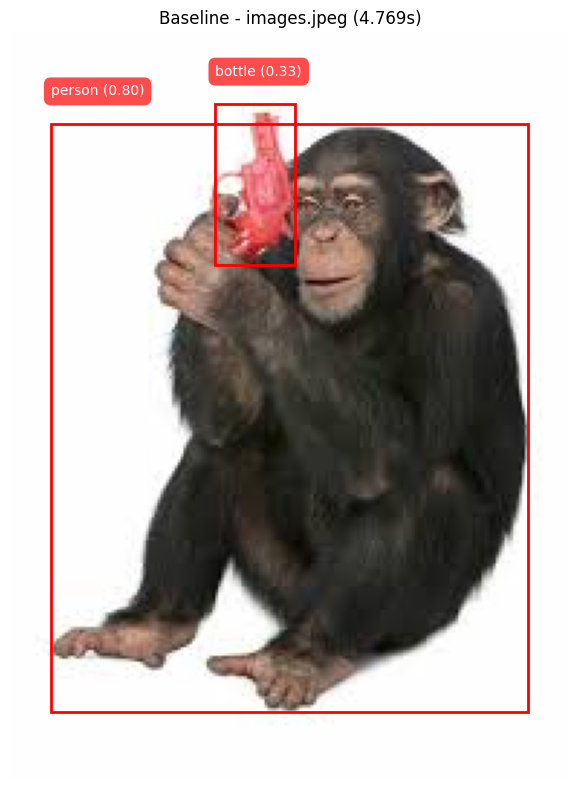


image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 1 cat, 63.7ms
Speed: 5.5ms preprocess, 63.7ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 1 cat, 11.0ms
Speed: 3.9ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
  1237371125_bars3.jpg: 0.101s


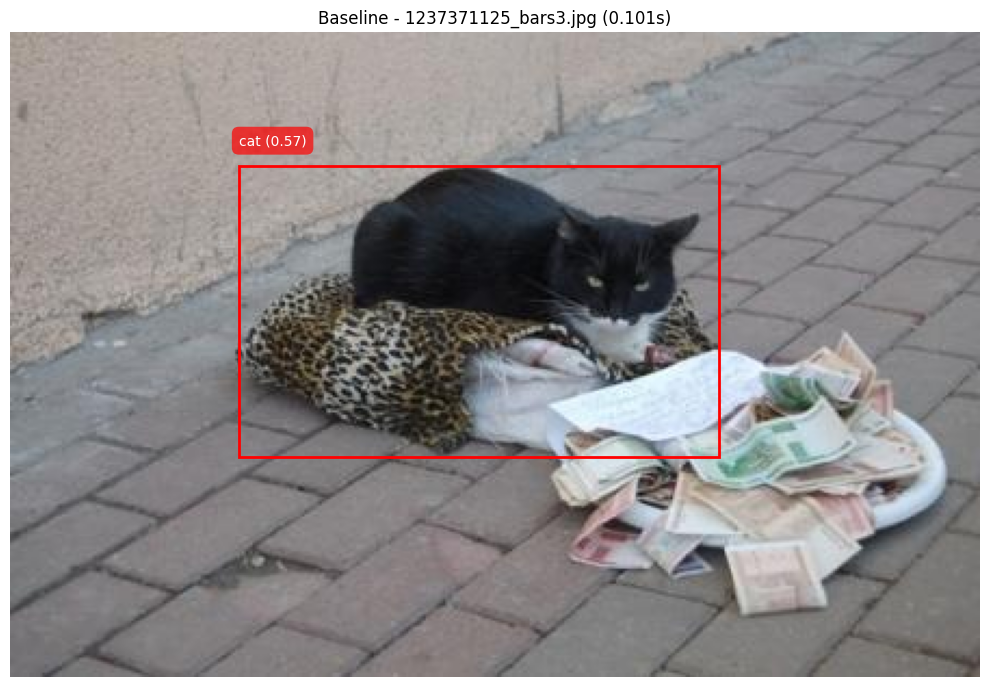


image 1/1 /content/photos test/fs119952b.jpg: 384x640 5 persons, 3 cars, 1 bus, 5 umbrellas, 71.9ms
Speed: 2.0ms preprocess, 71.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/photos test/fs119952b.jpg: 384x640 5 persons, 3 cars, 1 bus, 5 umbrellas, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
  fs119952b.jpg: 0.107s


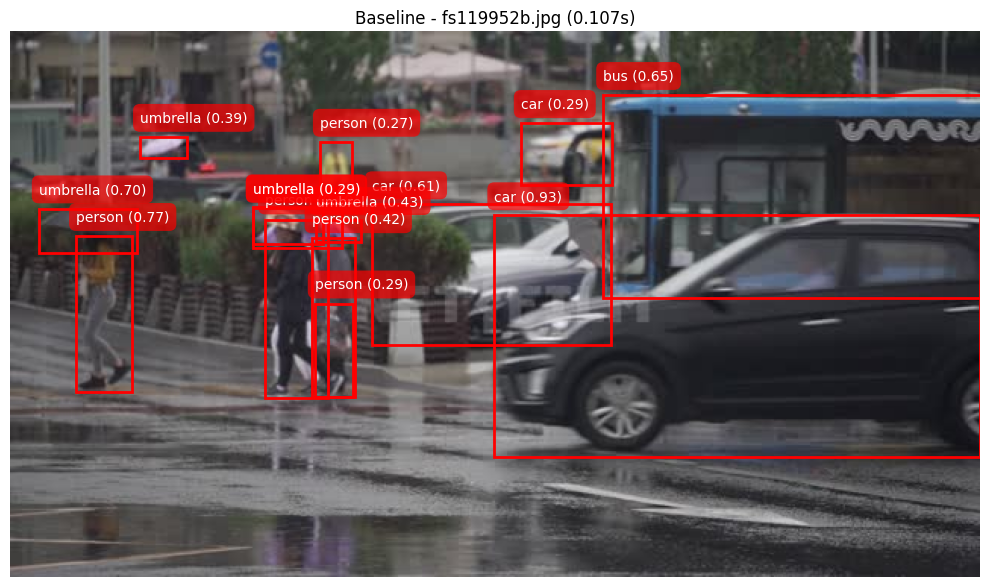


--- FP16 ---

image 1/1 /content/photos test/images.jpeg: 640x480 1 person, 1 bottle, 232.7ms
Speed: 8.0ms preprocess, 232.7ms inference, 23.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/photos test/images.jpeg: 640x480 1 person, 1 bottle, 133.7ms
Speed: 5.0ms preprocess, 133.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
  images.jpeg: 0.440s


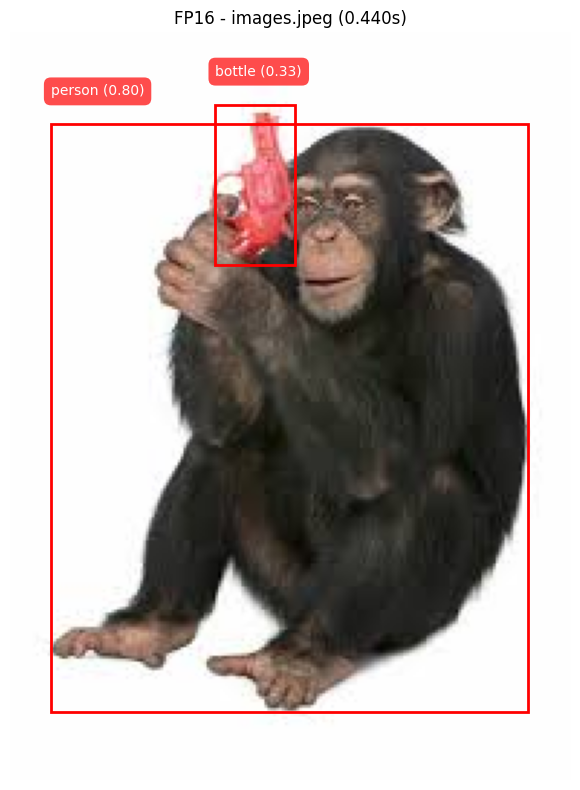


image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 1 cat, 155.2ms
Speed: 4.3ms preprocess, 155.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 1 cat, 125.8ms
Speed: 7.0ms preprocess, 125.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)
  1237371125_bars3.jpg: 0.325s


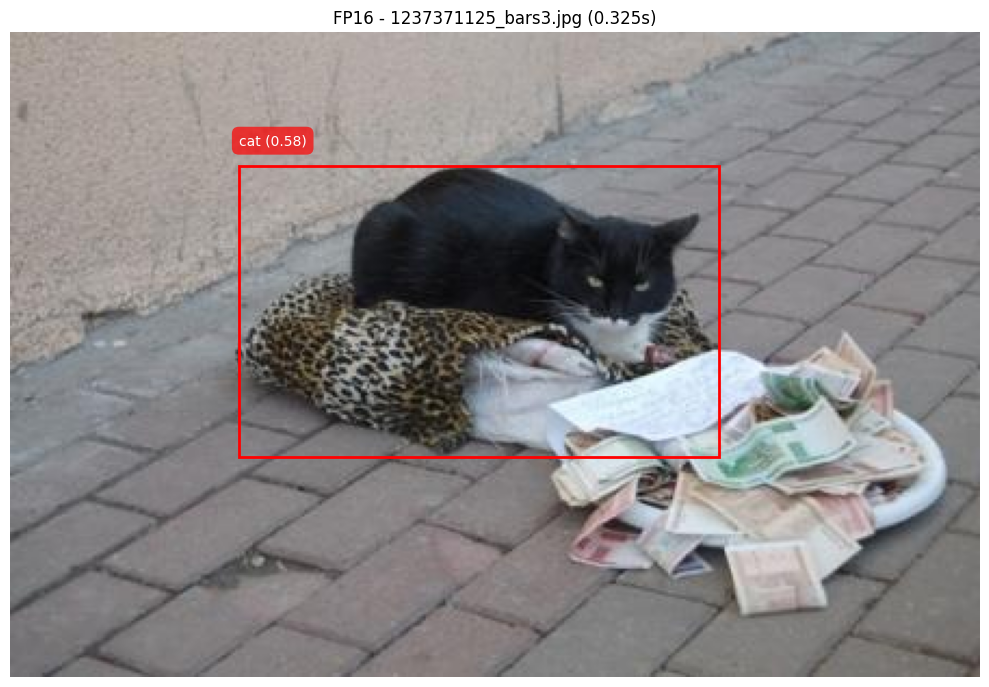


image 1/1 /content/photos test/fs119952b.jpg: 384x640 5 persons, 3 cars, 1 bus, 5 umbrellas, 147.3ms
Speed: 2.2ms preprocess, 147.3ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/photos test/fs119952b.jpg: 384x640 5 persons, 3 cars, 1 bus, 5 umbrellas, 137.7ms
Speed: 2.0ms preprocess, 137.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
  fs119952b.jpg: 0.323s


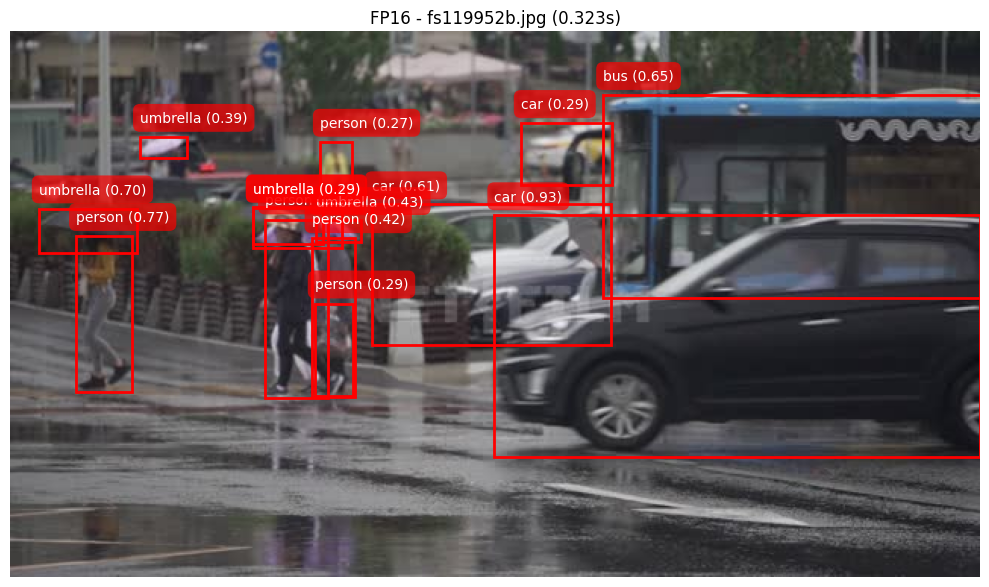


--- Pruning ---

image 1/1 /content/photos test/images.jpeg: 640x480 (no detections), 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/photos test/images.jpeg: 640x480 (no detections), 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)
  images.jpeg: 0.091s


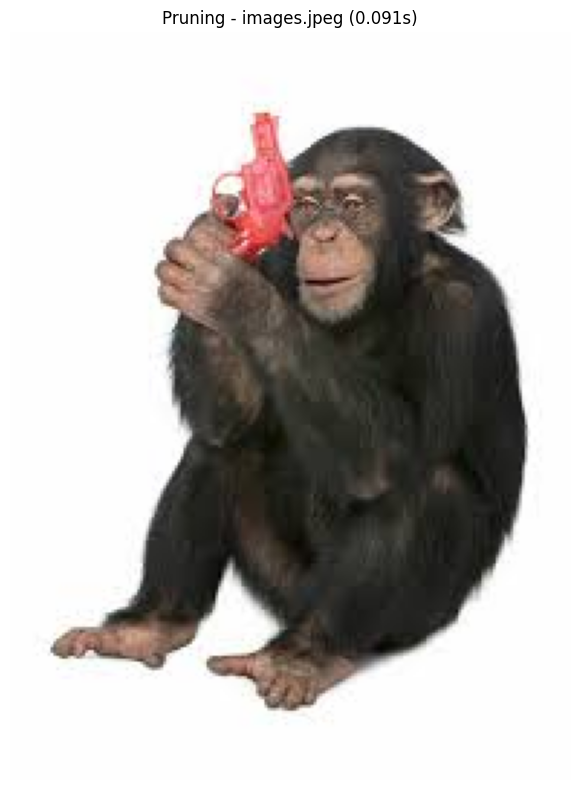


image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 (no detections), 12.6ms
Speed: 4.5ms preprocess, 12.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 (no detections), 11.3ms
Speed: 3.3ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)
  1237371125_bars3.jpg: 0.050s


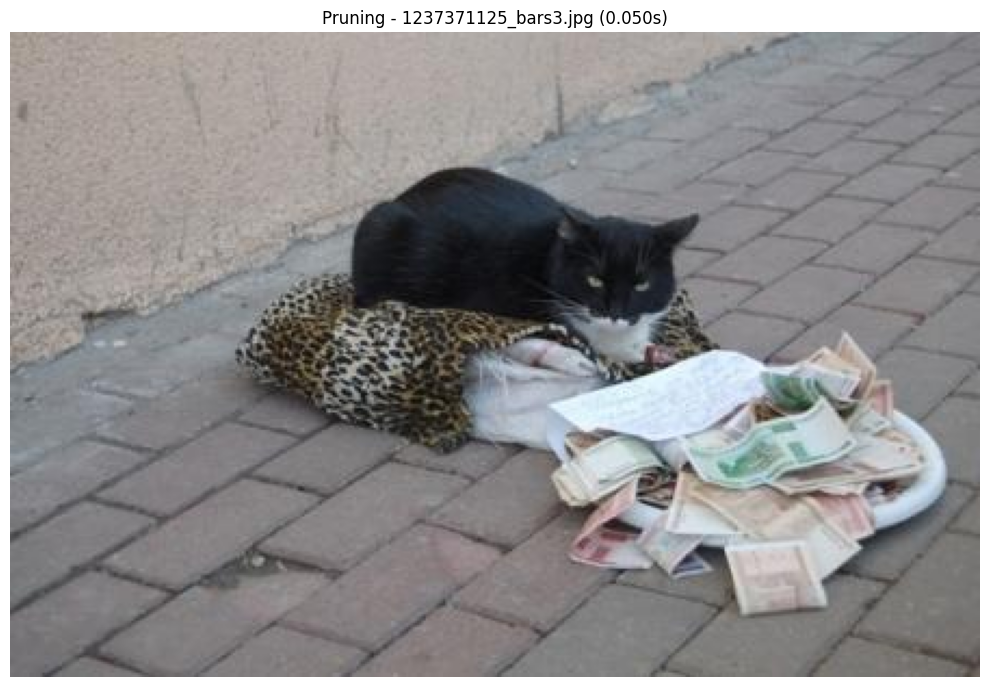


image 1/1 /content/photos test/fs119952b.jpg: 384x640 (no detections), 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/photos test/fs119952b.jpg: 384x640 (no detections), 12.2ms
Speed: 1.7ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
  fs119952b.jpg: 0.053s


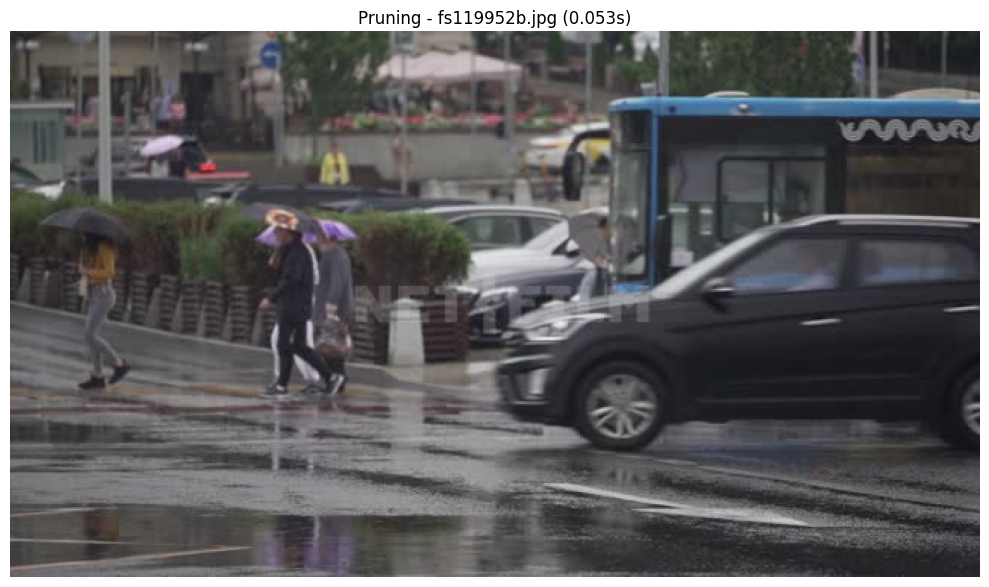


--- Quantization ---

image 1/1 /content/photos test/images.jpeg: 640x480 1 person, 1 bottle, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/photos test/images.jpeg: 640x480 1 person, 1 bottle, 12.6ms
Speed: 2.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
  images.jpeg: 0.077s


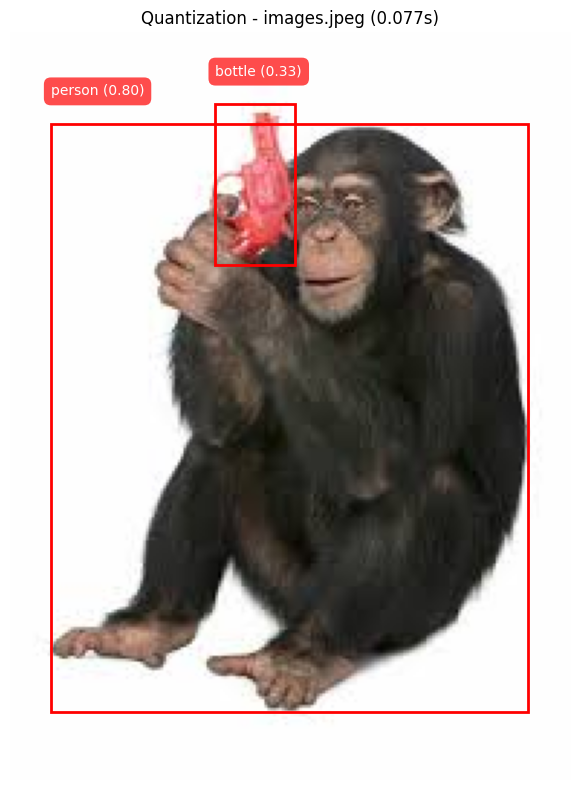


image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 1 cat, 9.8ms
Speed: 4.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 1 cat, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
  1237371125_bars3.jpg: 0.044s


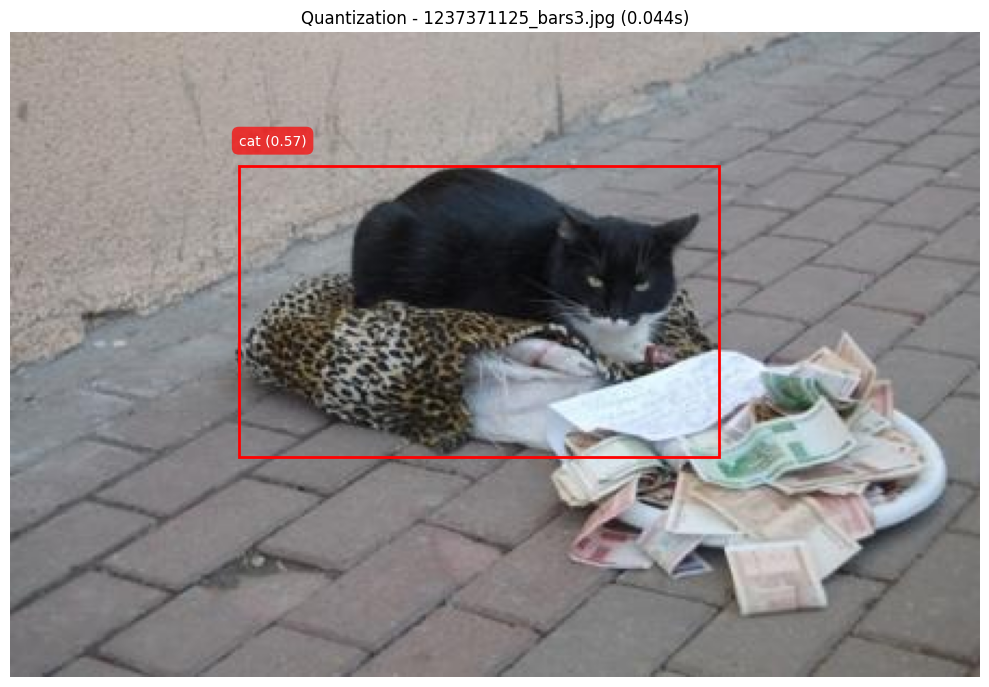


image 1/1 /content/photos test/fs119952b.jpg: 384x640 5 persons, 3 cars, 1 bus, 5 umbrellas, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/photos test/fs119952b.jpg: 384x640 5 persons, 3 cars, 1 bus, 5 umbrellas, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
  fs119952b.jpg: 0.044s


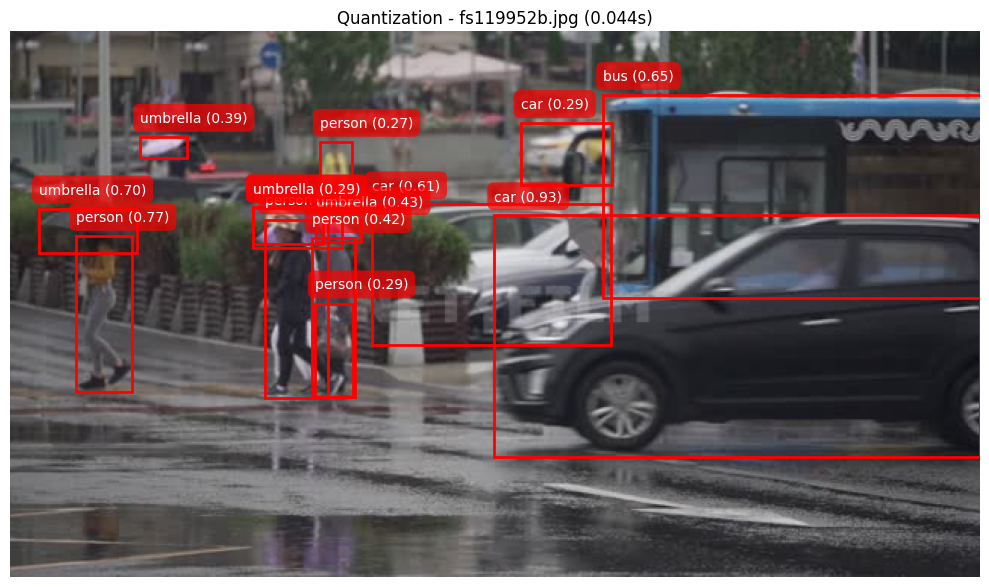


--- Pruning+Quantization ---

image 1/1 /content/photos test/images.jpeg: 640x480 (no detections), 14.4ms
Speed: 2.9ms preprocess, 14.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/photos test/images.jpeg: 640x480 (no detections), 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)
  images.jpeg: 0.087s


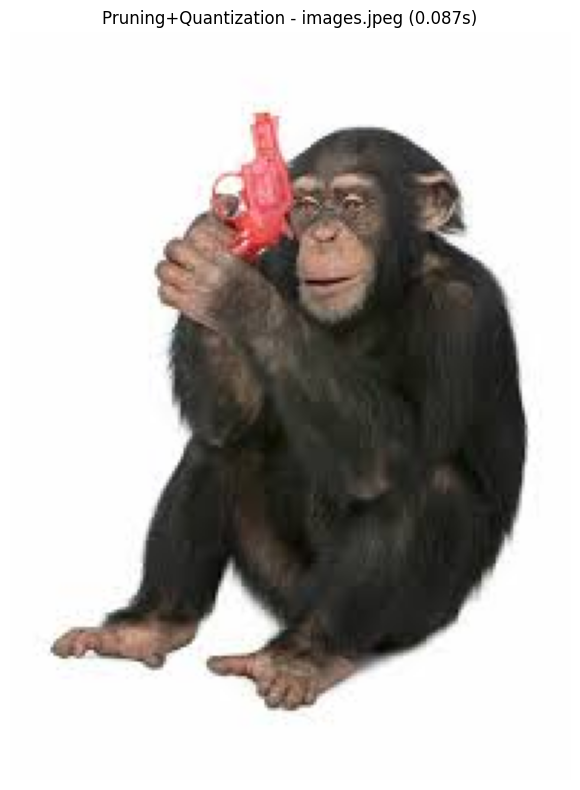


image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 (no detections), 23.7ms
Speed: 4.9ms preprocess, 23.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/photos test/1237371125_bars3.jpg: 448x640 (no detections), 17.6ms
Speed: 4.9ms preprocess, 17.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
  1237371125_bars3.jpg: 0.070s


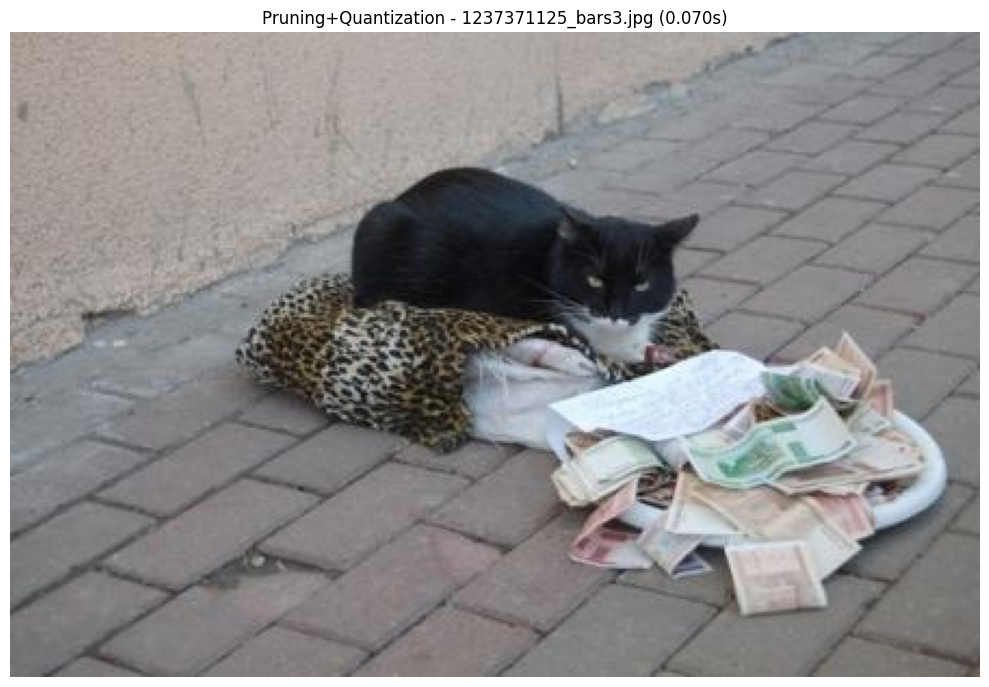


image 1/1 /content/photos test/fs119952b.jpg: 384x640 (no detections), 17.1ms
Speed: 1.8ms preprocess, 17.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/photos test/fs119952b.jpg: 384x640 (no detections), 18.4ms
Speed: 2.2ms preprocess, 18.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
  fs119952b.jpg: 0.063s


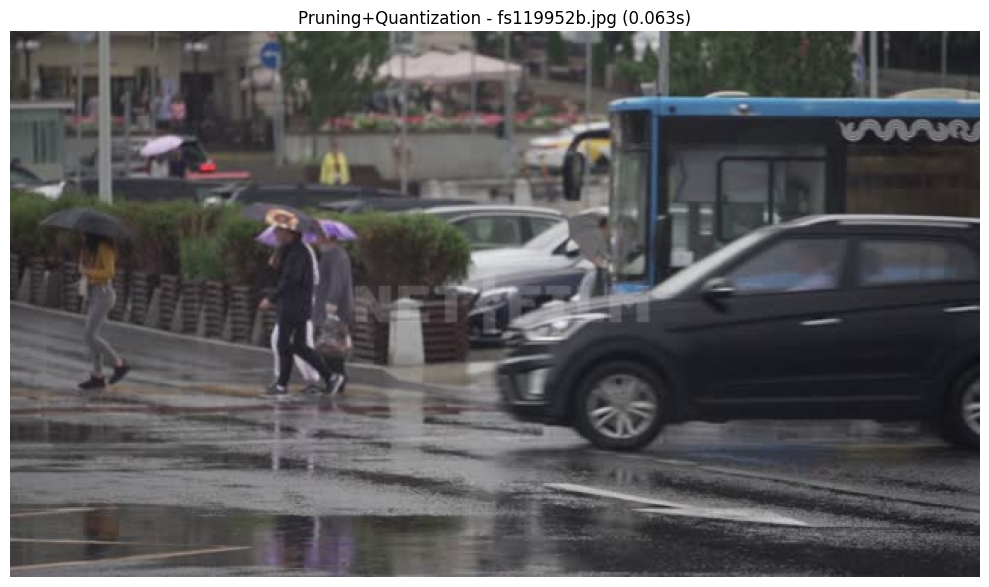

In [ ]:
for method_name, method_func in optimization_methods.items():
    print(f"\n--- {method_name} ---")
    optimized_model = copy.deepcopy(model_standard)
    method_results = []

    for img_path in test_images:
        time_taken, detection_results = measure_inference_time(method_func(optimized_model), img_path)
        method_results.append(time_taken)
        print(f"  {os.path.basename(img_path)}: {time_taken:.3f}s")
        visualize_results(img_path, detection_results, method_name, time_taken)

        detected_classes = []
        for result in detection_results:
            for box in result.boxes:
                cls = result.names[int(box.cls)]
                conf = box.conf.item()
                detected_classes.append(f"Class: {cls} (Confidence: {conf:.2f})")

        results_table.append([method_name, img_path, time_taken, detected_classes])

    results.append({
        "method": method_name,
        "times": method_results,
        "mean_time": np.mean(method_results),
        "std_time": np.std(method_results)
    })

# Оценка результатов

In [ ]:
# --- Сохранение результатов ---
df = pd.DataFrame(results)
RESULTS_CSV_PATH = "inference_results_table.csv"
df.to_csv(RESULTS_CSV_PATH, index=False)

df_styled = df.style.background_gradient(cmap='YlOrRd', subset=['mean_time'])
STYLED_TABLE_PATH = "styled_table.html"
df_styled.to_html(STYLED_TABLE_PATH)

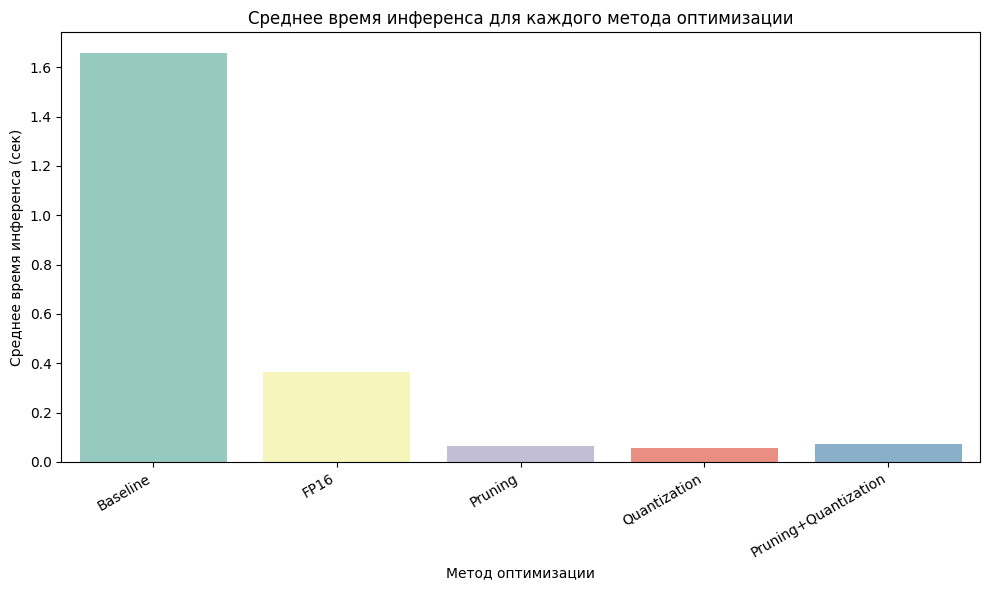

In [ ]:
# График 1: Среднее время по методам
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="method", y="mean_time",  palette="Set3", hue="method", legend=False, errorbar=None)  # Исправлено: hue="method", legend=False, убран yerr
plt.title("Среднее время инференса для каждого метода оптимизации")
plt.ylabel("Среднее время инференса (сек)")
plt.xlabel("Метод оптимизации")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
BARPLOT_2_PATH = "barplot_mean_times.png"
plt.savefig(BARPLOT_2_PATH)
plt.show()

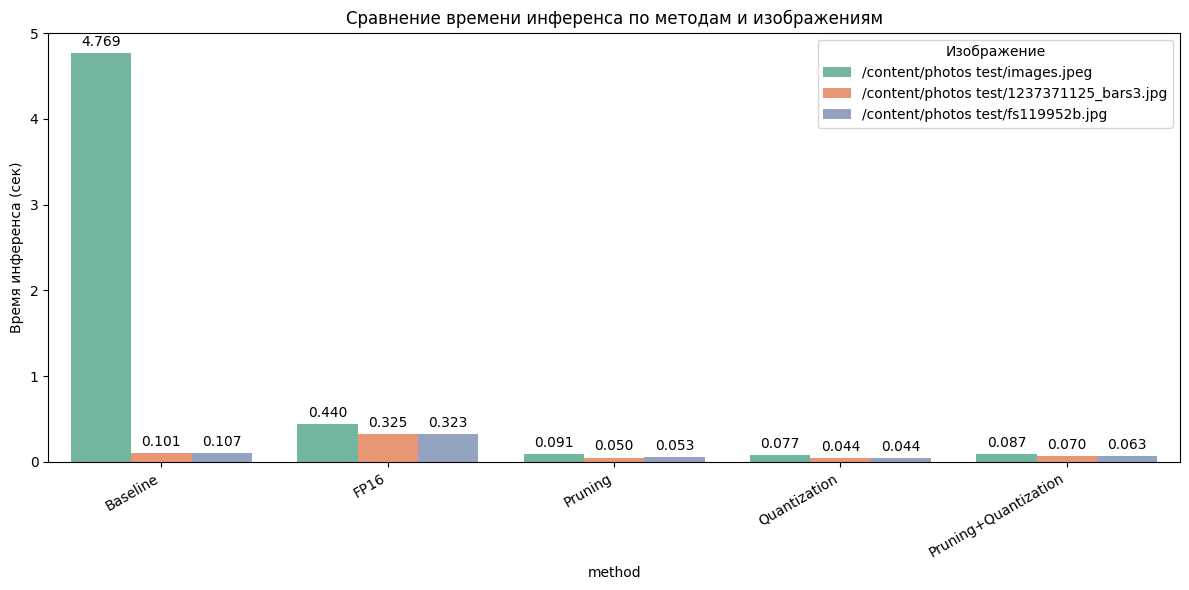

In [ ]:
# График 2: Время инференса для каждого изображения по каждому методу
df_long = df.explode('times')
df_long['times'] = df_long['times'].astype(float)
df_long = df_long.rename(columns={'times': 'Время инференса (сек)'})

# Создаем список с названиями изображений, повторяющийся для каждого метода
image_names = []
for method in df['method'].unique():
    image_names.extend(test_images)

df_long['Изображение'] = image_names

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_long, x="method", y="Время инференса (сек)", hue="Изображение", palette="Set2")
plt.title("Сравнение времени инференса по методам и изображениям")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

# Добавляем значения времени над каждым столбцом
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)  # Отображаем 3 знака после запятой

BARPLOT_1_PATH = "barplot_methods_images.png"
plt.savefig(BARPLOT_1_PATH)
plt.show()

In [ ]:
# --- Создание rich таблицы ---  (этот блок после основного цикла)
from rich.console import Console
from rich.table import Table

console = Console()
table = Table(title="Детальное сравнение методов оптимизации", show_lines=True)

table.add_column("Метод", justify="left", style="cyan", no_wrap=True)
table.add_column("Изображение", justify="left", style="magenta")
table.add_column("Время инференса (с)", justify="right", style="green")
table.add_column("Обнаруженные классы", justify="left", style="white", overflow="fold")


for entry in results_table:
    method_name, img_path, time_taken, detected_classes = entry
    formatted_classes = "\n".join(detected_classes)
    table.add_row(
        method_name,
        os.path.basename(img_path),
        f"{time_taken:.3f}",
        formatted_classes,
    )

console.print(table)


                                 Детальное сравнение методов оптимизации                                  
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Метод                ┃ Изображение          ┃ Время инференса (с) ┃ Обнаруженные классы                ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Baseline             │ images.jpeg          │               4.769 │ Class: person (Confidence: 0.80)   │
│                      │                      │                     │ Class: bottle (Confidence: 0.33)   │
├──────────────────────┼──────────────────────┼─────────────────────┼────────────────────────────────────┤
│ Baseline             │ 1237371125_bars3.jpg │               0.101 │ Class: cat (Confidence: 0.57)      │
├──────────────────────┼──────────────────────┼─────────────────────┼────────────────────────────────────┤
│ Baseline             │ fs119952b.jpg        │               0.107 │ Class: car (Confidence: 0.93)      │
│                      │                      │                     │ Class: person (Confidence: 0.77)   │
│                      │                      │                     │ Class: umbrella (Confidence: 0.70) │
│                      │                      │                     │ Class: person (Confidence: 0.69)   │
│                      │                      │                     │ Class: bus (Confidence: 0.65)      │
│                      │                      │                     │ Class: car (Confidence: 0.61)      │
│                      │                      │                     │ Class: umbrella (Confidence: 0.47) │
│                      │                      │                     │ Class: umbrella (Confidence: 0.43) │
│                      │                      │                     │ Class: person (Confidence: 0.42)   │
│                      │                      │                     │ Class: umbrella (Confidence: 0.39) │
│                      │                      │                     │ Class: umbrella (Confidence: 0.29) │
│                      │                      │                     │ Class: car (Confidence: 0.29)      │
│                      │                      │                     │ Class: person (Confidence: 0.29)   │
│                      │                      │                     │ Class: person (Confidence: 0.27)   │
├──────────────────────┼──────────────────────┼─────────────────────┼────────────────────────────────────┤
│ FP16                 │ images.jpeg          │               0.440 │ Class: person (Confidence: 0.80)   │
│                      │                      │                     │ Class: bottle (Confidence: 0.33)   │
├──────────────────────┼──────────────────────┼─────────────────────┼────────────────────────────────────┤
│ FP16                 │ 1237371125_bars3.jpg │               0.325 │ Class: cat (Confidence: 0.58)      │
├──────────────────────┼──────────────────────┼─────────────────────┼────────────────────────────────────┤
│ FP16                 │ fs119952b.jpg        │               0.323 │ Class: car (Confidence: 0.93)      │
│                      │                      │                     │ Class: person (Confidence: 0.77)   │
│                      │                      │                     │ Class: umbrella (Confidence: 0.70) │
│                      │                      │                     │ Class: person (Confidence: 0.69)   │
│                      │                      │                     │ Class: bus (Confidence: 0.65)      │
│                      │                      │                     │ Class: car (Confidence: 0.61)      │
│                      │                      │                     │ Class: umbrella (Confidence: 0.47) │
│                      │                      │                     │ Class: umbrella (Confidence: 0.43) │
│                      │                 

In [ ]:
print(f"\nРезультаты сохранены в {RESULTS_CSV_PATH}, {STYLED_TABLE_PATH}, {BARPLOT_1_PATH}, {BARPLOT_2_PATH} и изображениях с детекциями.")


Результаты сохранены в inference_results_table.csv, styled_table.html, barplot_methods_images.png, barplot_mean_times.png и изображениях с детекциями.


Результаты показывают интересную картину.  Как ожидалось, все методы оптимизации, кроме Pruning и Pruning+Quantization,  демонстрируют снижение времени инференса по сравнению с Baseline.  Однако, Pruning и Pruning+Quantization привели к полной потере способности модели детектировать объекты. Это указывает на **некорректное применение pruning** в данном случае.  Скорее всего, слишком большая часть весов была удалена (PRUNING_AMOUNT = 0.3), что сделало модель нефункциональной.

**FP16** показал значительное улучшение, уменьшив время инференса в среднем более чем в 3 раза по сравнению с Baseline. Это хороший результат, демонстрирующий эффективность использования полуточной арифметики.

**Quantization** также показал  уменьшение времени инференса, хотя и менее выраженное, чем у FP16, сохранив при этом способность модели корректно детектировать объекты и их классы.

**Ключевые наблюдения:**

* **Pruning требует более тонкой настройки.**  Значение PRUNING_AMOUNT = 0.3 оказалось слишком агрессивным, что привело к потере функциональности модели.  Необходимо провести эксперименты с меньшими значениями этого параметра,  например, 0.1 или 0.05, чтобы найти оптимальный баланс между размером модели и точностью.
* **FP16 – наиболее эффективный метод**  в данном случае, обеспечивающий значительное ускорение без потери точности.  Это делает его перспективным кандидатом для использования на мобильных устройствах.
* **Quantization –  менее эффективный**, чем FP16,  но всё ещё даёт прирост производительности.  Может быть полезен в сочетании с другими методами.

**Дальнейшие шаги:**

1. **Исследовать Pruning с меньшими значениями PRUNING_AMOUNT.** Необходимо найти значение, которое позволит уменьшить размер модели без существенной потери точности.
2. **Протестировать комбинацию FP16 и Quantization.**  Возможно, совместное применение этих методов даст еще больший прирост производительности.
3. **Оценить влияние оптимизаций на точность детекции.** Хотя в данном эксперименте Pruning+Quantization полностью нарушил работу модели, а остальные методы сохранили обнаружение тех же классов,  в общем случае оптимизации могут влиять на точность.  Для более полной картины необходимо провести количественную оценку точности (например, mAP) для каждого метода.
4. **Рассмотреть другие методы оптимизации.**  Например, квантование с учетом потери информации (Quantization Aware Training) может дать лучшие результаты, чем динамическое квантование.

В целом, FP16 представляется наиболее перспективным методом для оптимизации YOLOv8 на мобильных устройствах,  однако  дальнейшие исследования с Pruning и другими методами могут привести к еще более эффективным решениям.  Ключевым моментом является поиск баланса между скоростью инференса и точностью детекции.


На huggingface лежит модель YoloV7 Tiny от qualcomm. Где они оптимизировали и квантовали модель с помощью ONNX, QNN и TFLite.

ONNX (Open Neural Network Exchange) и TFLite (TensorFlow Lite) — это два популярных формата для представления нейронных сетей, предназначенных для развертывания на различных платформах, включая мобильные устройства и встраиваемые системы.  Хотя оба предназначены для повышения переносимости моделей, они имеют разные особенности и подходят для разных задач.

**ONNX (Open Neural Network Exchange):**

* **Открытый стандарт:** ONNX является открытым стандартом, разработанным Microsoft, Facebook (Meta) и другими компаниями. Это означает, что он не привязан к конкретной платформе или фреймворку глубокого обучения.  Модели, экспортированные в ONNX, могут быть импортированы и использованы различными инструментами и фреймворками, такими как PyTorch, TensorFlow, MXNet, scikit-learn и т.д.
* **Переносимость:**  Ключевое преимущество ONNX — его переносимость. Вы можете обучать модель в одном фреймворке (например, PyTorch), экспортировать ее в ONNX и затем выполнять инференс в другом фреймворке (например, TensorFlow Lite на мобильном устройстве) без необходимости переобучения.
* **Поддержка широкого спектра операций:** ONNX поддерживает широкий спектр операций, используемых в современных нейронных сетях. Однако, не все операции, поддерживаемые отдельными фреймворками, могут быть представлены в ONNX.
* **Оптимизация:** ONNX-модели могут быть оптимизированы различными инструментами для повышения производительности на целевых платформах.  Например, ONNX Runtime позволяет оптимизировать модель под конкретную архитектуру процессора или использовать аппаратное ускорение.

**TFLite (TensorFlow Lite):**

* **Фреймворк-специфичный:** TFLite является облегченной версией TensorFlow, специально предназначенной для развертывания моделей на мобильных устройствах, встраиваемых системах и IoT-устройствах.  Он тесно связан с TensorFlow и оптимизирован для работы на устройствах с ограниченными ресурсами.
* **Высокая производительность на мобильных устройствах:** TFLite оптимизирован для работы на мобильных платформах и обычно обеспечивает высокую производительность.
* **Квантование:**  TFLite предоставляет мощные возможности квантования моделей, позволяющие уменьшить размер модели и ускорить инференс за счет снижения точности вычислений. Квантование — это критичный аспект для мобильных приложений, где ограничены ресурсы памяти и вычислительной мощности.
* **Ограниченная переносимость:** Хотя вы можете конвертировать модели из других фреймворков в TFLite, это не всегда просто, и может потребовать дополнительных шагов.  TFLite не обладает такой же универсальностью, как ONNX.


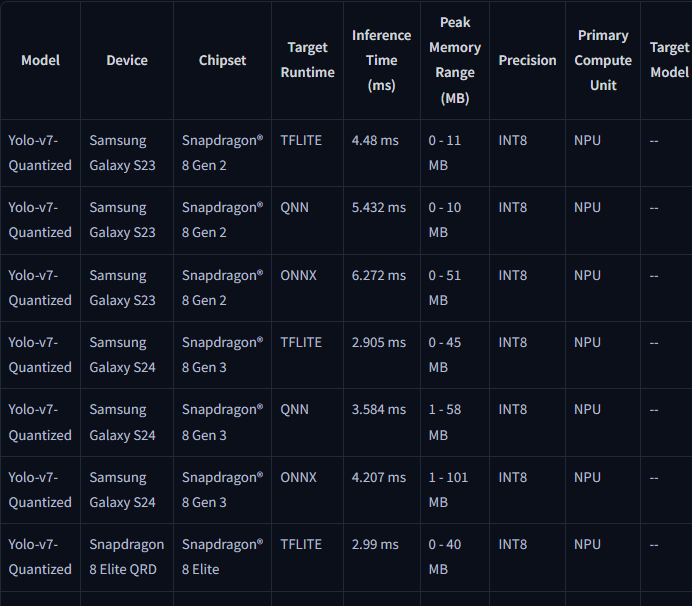

**Вот что означают столбцы:**

* **Model:**  Название модели — квантованная версия YOLOv7.  Квантование (INT8) означает, что модель использует 8-битные целые числа для вычислений, что повышает эффективность.
* **Device:** Название устройства, на котором проводилось тестирование (различные модели смартфонов Samsung и Qualcomm чипсеты).  Некоторые записи помечены как "(Proxy)", что, вероятно, указывает на использование эмулятора или приблизительной модели устройства для тестирования.
* **Chipset:**  Набор микросхем (процессор) устройства.
* **Target Runtime:** Среда выполнения, используемая для запуска модели (TFLITE, QNN, ONNX).
* **Inference Time (ms):** Время инференса (вывода) модели в миллисекундах. Это ключевой показатель производительности.
* **Peak Memory Range (MB):** Диапазон пикового использования памяти моделью в мегабайтах.
* **Precision:** Точность вычислений, в данном случае INT8 (8-битные целые числа).
* **Primary Compute Unit:** Основной вычислительный блок, используемый для выполнения инференса (NPU - Neural Processing Unit, GPU - Graphics Processing Unit).  NPU — специализированный процессор для нейронных сетей, обычно более эффективный для таких задач.
* **Target Model:**  Этот столбец пуст (--) во всех строках, что означает, что нет информации о конкретной целевой модели, используемой для оптимизации.

**Основные выводы:**

* **TFLite обычно быстрее, чем QNN и ONNX:**  В большинстве случаев TFLITE демонстрирует наименьшее время инференса.
* **Производительность зависит от аппаратного обеспечения:**  Время инференса сильно варьируется в зависимости от чипсета и устройства.  Более современные чипсеты (Snapdragon 8 Gen 3) показывают значительно лучшие результаты, чем более старые (QCS6490 Proxy).
* **ONNX обычно использует больше памяти:**  ONNX Runtime, как правило, потребляет больше памяти, чем TFLITE и QNN.
* **QNN не всегда быстрее TFLITE:**  В некоторых случаях QNN показывает даже более высокое время инференса, чем TFLITE. Это может зависеть от конкретной реализации и оптимизации на различных платформах.
* **GPU может быть медленнее NPU:** Запись с RB5 (Proxy) показывает, что использование GPU (вместо NPU) может существенно снизить производительность.

В целом, таблица демонстрирует, что выбор среды выполнения существенно влияет на производительность YOLOv7, и оптимальный выбор зависит от конкретного устройства и требований к производительности.  Результаты указывают на то, что TFLite является хорошим кандидатом для многих платформ, но тестирование с конкретным оборудованием необходимо для определения оптимального решения.
